# Measuring Dave Portnoy's Pizza Review Consistency (2016-2023)
Since 2013, Dave Portnoy has reviewed nearly 2,000 pizzerias where, after "one bite", he gives a score from 0-10. These reviews are extremely popular, often receiving hundreds of thousands of views. They can also make a significant impact, with multiple instances where high scores have generated significant press and increased business for pizzerias across the United States. 

The goal of this study is to explore whether Dave's scores are consistent. Meaning, have Dave's scores changed over time and, if so, why? To measure this, I first collected all of Dave's scores between 2013 and 2024, then filtering out the years with a low (<100 reviews) and the current year (2024). I then ended up with a dataset that includes approximately 1700 reviews. 

Once the data had been prepared, I ran three analyses:
- Mean Pizza Score over Time
- Count of Scores by State per Year
- Mean Pizza Score by Type over Time

These analyses discovered the following key observations:
1. There are two distinct review periods, 2016-2019 and 2020-2023 which are made distinct by noticeable differences in annual pizza score mean and variance values. 2016-2019 saw lower means with high variance while 2020-2023 saw a slightly higher mean with significantly lower variance.
2. Between 2019 and 2020, we see a significant shift in review location. Between 2016-2019, the majority of reviews are from New York state pizzerias (mostly within New York City). In 2020-2023, the share of New York reviews falls by over 50%, while we see a significant rise in Florida, New Jersey, and 'Other' states. This geographic shift correlates to the differences in the mean & variance we observed in the statistical analysis. I believe this observation suggests that a sampling bias is affecting the average annual pizza score. Essentially, Dave is visiting higher quality pizza locations whereas, when most of its reviews were confined to NYC, the selection was more random. This is corroborated by some qualitative findings in the the reviews themselves, where Dave multiple time suggests that during trips his assistant is selecting pizzerias based on their scores in the One Bite App.
3. To control for this sampling bias, I randomly sampled 200 reviews and labelled each by the Pizza Type. If Dave's scoring is indeed consistent, we should expect to see minimal change in the reviews for specific Pizza Types. This analysis shows little to no change in Pizza Scores by Type over time, suggesting Dave's scoring is indeed, directionally, consistent. 

So, in conclusion, Dave's Mean Score has indeed increased since 2016. However, this can be accounted for by a sampling bias (he's sampling from higher rated restaurants). When comparing pizza's by type, however, we see little change over time, suggesting his scoring is indeed consistent. 



In [2]:
#IMPORTS
import seaborn as sns
import math
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
from scipy.stats import variation  
import statsmodels.api as sm
from statsmodels.formula.api import ols



### Step 1: Collect Data
In this step, I import and prepare two key datasets - all Pizza Reviews (reviews) and a randomly sampled dataset (reviews_by_type), which is used for the third analysis.

In [9]:
#Import scraped_data_may24 csv
reviews = pd.read_csv('scraped_data_may24.csv')
reviews = reviews.rename(columns={'Score:': 'Score'})
reviews['Date'] = pd.to_datetime(reviews['Date'])
reviews['Year'] = reviews['Date'].dt.year
reviews = reviews[(reviews['Year']>=2016) & (reviews['Year']<2024)]


#Import the randomly sampled, labelled, csv
reviews_by_type = pd.read_csv('randomly_sampled_reviews.csv')
reviews_by_type['Date'] = pd.to_datetime(reviews_by_type['Date'])
reviews_by_type['Pizza Attributes'] = reviews_by_type['Pizza Attributes'].str.split(',')
reviews_by_type['Year'] = pd.to_datetime(reviews_by_type['Year'], format='%Y')

#Pizza Types:
neopolitan_reviews = reviews_by_type[reviews_by_type['Pizza Type'] == 'Neopolitan']
football_pizza_reviews = reviews_by_type[reviews_by_type['Pizza Type'] == 'Football Pizza']
new_york_style_reviews = reviews_by_type[reviews_by_type['Pizza Type'] == 'New York Style']

#Pre/Post 2020 datasets
pre_2020_reviews = reviews[reviews['Year'] < 2020]
post_2020_reviews = reviews[reviews['Year'] >= 2020]


In [10]:
#Key functions used
def trend_line(data):
    x = mdates.date2num(data['Date'])
    y = data['Score']

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)   

    return [x,y,z,p(x)]

### Analysis 1: How has Dave's Scores changed overtime?
My first step is to gain a high level understanding of the data. Specifically, I want figure out whether Dave's scores have, on average, changed over time. To accomplish this, I complete a basic time-series analysis where I plot the annual mean pizza score from 2016-2023. To study the variation, which is a key determinant in consistency (low variance suggests higher consistency), 


In [11]:
#Key Tables
mean_review_by_year = pd.pivot_table(reviews, values='Score', index='Year', aggfunc='mean')
std_review_by_year = pd.pivot_table(reviews, values='Score', index='Year', aggfunc='std')


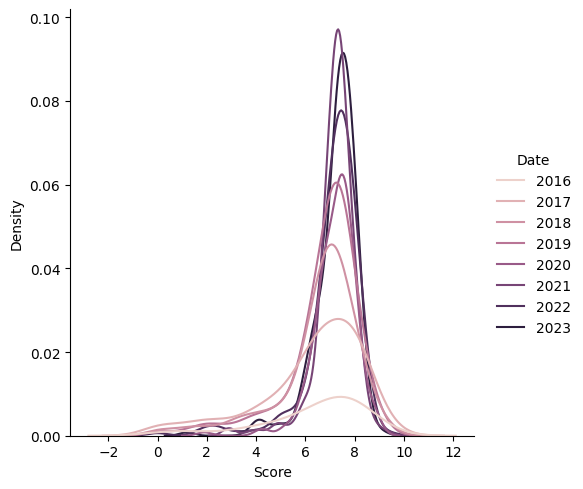

In [12]:
#Plot 1: Distribution plot
sns.displot(data=reviews, x=reviews['Score'], kind="kde", hue=reviews['Date'].dt.year)

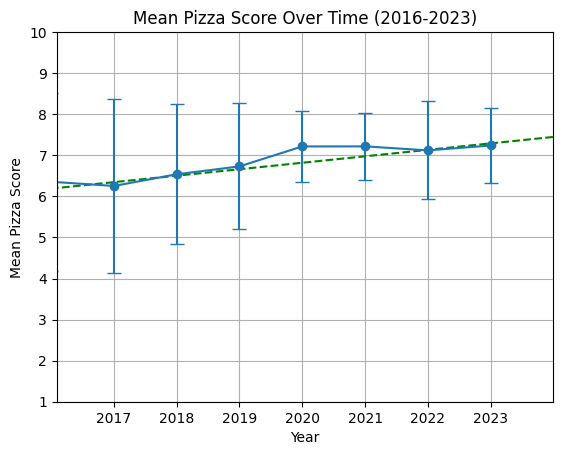

In [13]:

# Convert years to datetime for consistent plotting
mean_review_by_year.index = pd.to_datetime(mean_review_by_year.index, format='%Y')
std_review_by_year.index = pd.to_datetime(std_review_by_year.index, format='%Y')

# Plot error bars
plt.errorbar(mean_review_by_year.index, mean_review_by_year['Score'], yerr=std_review_by_year['Score'], fmt='-o', capsize=5)

# Plot trendline
trend_data = trend_line(reviews)
plt.plot(mdates.num2date(trend_data[0]), trend_data[3], "g--")

plt.xlabel("Year")
plt.ylabel("Mean Pizza Score")
plt.title('Mean Pizza Score Over Time (2016-2023)')
plt.xlim(min(reviews['Date']), max(reviews['Date']))
plt.ylim((1, 10))
plt.grid(True)
plt.show()

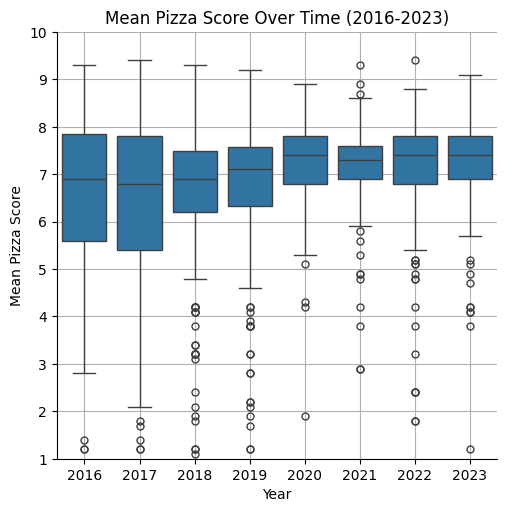

In [14]:
#Table 1: Annual Mean Pizza Score
sns.catplot(data=reviews, x=reviews['Year'], y=reviews['Score'], kind="box")
#sns.catplot(data=reviews, x=reviews['Year'], y=reviews['Score:'], kind="violin", inner='stick')
#sns.despine(offset=10, trim=True)
plt.xlabel("Year")
plt.ylabel("Mean Pizza Score")
plt.title('Mean Pizza Score Over Time (2016-2023)')
plt.ylim((1, 10))
plt.grid(True)
plt.show()



In [15]:
#ANOVA Test
anova = ols('Score ~ C(Year)', data=reviews).fit()
anova_table = sm.stats.anova_lm(anova, typ=2)

print(anova_table)

# Perform ANOVA for each period
model_pre_2020 = ols('Score ~ C(Year)', data=pre_2020_reviews).fit()
anova_table_pre_2020 = sm.stats.anova_lm(model_pre_2020, typ=2)
print("ANOVA results for 2016-2019:")
print(anova_table_pre_2020)

model_post_2020 = ols('Score ~ C(Year)', data=post_2020_reviews).fit()
anova_table_post_2020 = sm.stats.anova_lm(model_post_2020, typ=2)
print("ANOVA results for 2020-2023:")
print(anova_table_post_2020)



               sum_sq      df          F        PR(>F)
C(Year)    216.492841     7.0  15.540684  8.116247e-20
Residual  3208.044659  1612.0        NaN           NaN
ANOVA results for 2016-2019:
               sum_sq     df        F    PR(>F)
C(Year)     26.500349    3.0  2.66608  0.046855
Residual  2378.929582  718.0      NaN       NaN
ANOVA results for 2020-2023:
              sum_sq     df         F    PR(>F)
C(Year)     2.017395    3.0  0.725091  0.537118
Residual  829.115077  894.0       NaN       NaN


### Analysis 2: Has review location changed over time & What is its impact?
In this analysis, I focus on understanding how the location of reviews has changed over time to try and understand the mean & variance difference between 2016-2019 and 2020-2023. To accomplish this, I created a stacked barchot plotting the count of reviews by state each year. Then I plotted the annual state averages compared to the total annual averages.

In [16]:
#Key Data

#These states will have their own bar chart. The rest will be merged into an 'Other' category to keep the plot clean.
specified_states = [' NY', ' CT', ' FL', ' IL', ' MA', ' NJ']

#these are not states or regions
reviews = reviews[(reviews['State'] != ' XGL') & (reviews['State'] != ' WNM') & (reviews['State'] != ' null')]
reviews['State_Grouped'] = reviews['State'].apply(lambda x: x if x in specified_states else 'Other')
review_count_by_state_per_year = pd.pivot_table(reviews, values='Name', index='Year', columns='State_Grouped', aggfunc='count', fill_value=0)

C:\Users\ncare\AppData\Local\Temp\ipykernel_6236\1810694703.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  reviews['State_Grouped'] = reviews['State'].apply(lambda x: x if x in specified_states else 'Other')


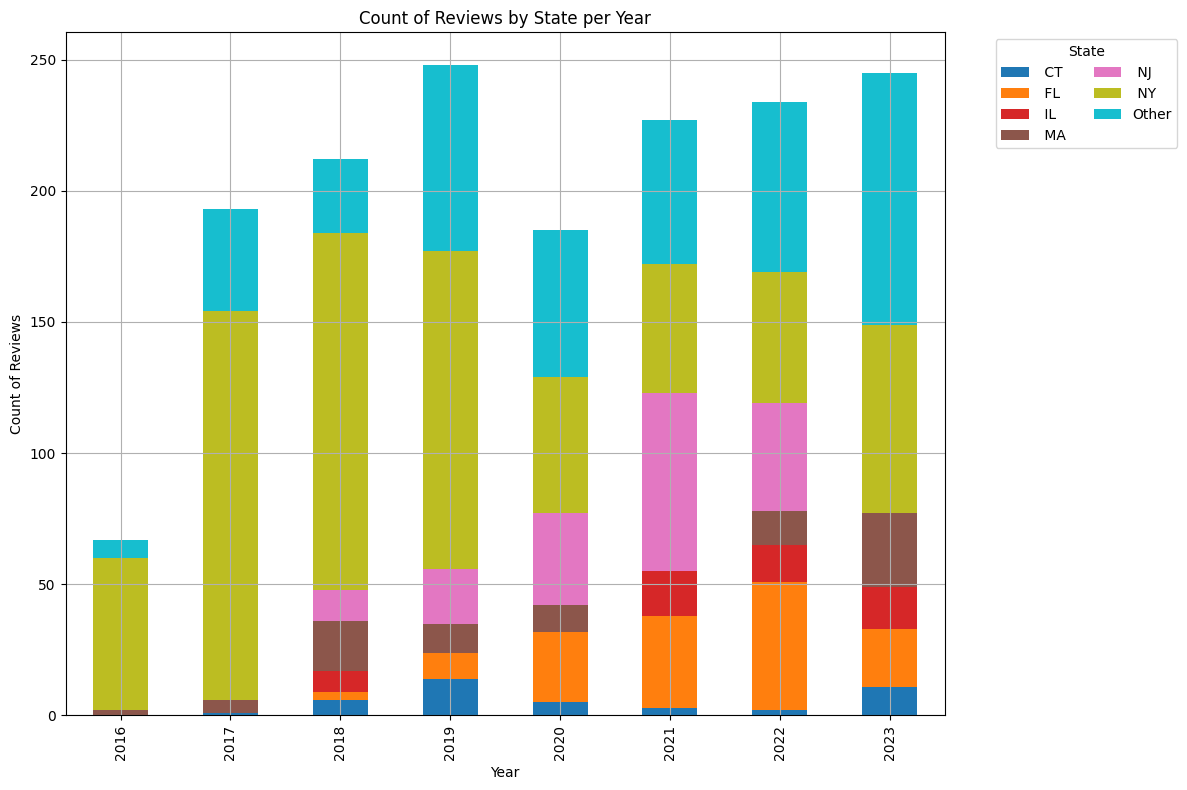

In [17]:
colors = plt.get_cmap('tab10', len(review_count_by_state_per_year.columns))
ax = review_count_by_state_per_year.plot(kind='bar', stacked=True, figsize=(12, 8), color=[colors(i) for i in range(len(review_count_by_state_per_year.columns))])
plt.title('Count of Reviews by State per Year')
plt.xlabel('Year')
plt.ylabel('Count of Reviews')
plt.legend(title='State', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=2)  # Adjusted legend position and columns
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
#ANOVA Test
anova = ols('Score ~ C(State)', data=reviews).fit()
anova_table = sm.stats.anova_lm(anova, typ=2)

print(anova_table)

               sum_sq      df         F        PR(>F)
C(State)   261.824712    36.0  3.657863  3.306177e-12
Residual  3129.575562  1574.0       NaN           NaN


### Analysis 3: Do we see the same trends when measuring scores by pizza type?

In Analysis #1, we saw statistically significant differences in the annual mean pizza score pre and post-2020. In Analysis #2, we identify a possible cause: sampling bias. In this final analysis, we seek an alternative approach to determining whether Dave's scores are consistent: measuring scores by pizza type. Here's the general principle. For a given Pizza Type, Dave's score should be independent of time. To illustrate this idea, let's imagine we have a type of Pizza called Pizza P. In our example, Dave reviews two Pizza P's, one in 2017 and once in 2023. If Dave's scoring is truly consistent, we shouldn't see a change in score. Now, accounting for some variance, we should see **minimal** changes over time. 

To conduct this analysis, I randomly sampled 200 (~10%) of the reviews dataset and manually viewed each review, labelling a pizza by its type. For this analysis, we only care about three types:

- Neapolitan Pizza
- Football Pizza
- New York Style Pizza

I then plot each and conduct a regression analysis to compare the trend line slope between the pizza type & the sampled set, determining if the slope difference is statistically significant.  

Slope of the trendline: 0.00034176682783613403


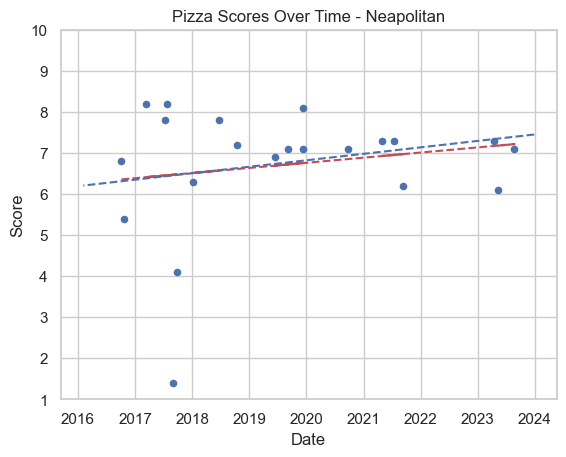

In [122]:

# Create the relplot
#rel_plot = sns.relplot(data=football_pizza_reviews, x='Date', y='Score:', kind='scatter')

x = mdates.date2num(neopolitan_reviews['Date'])
y = neopolitan_reviews['Score:']

z = np.polyfit(x, y, 1)
p = np.poly1d(z)

#print slope
slope = z[0]
print("Slope of the trendline:", slope)

neopolitan_reviews.plot('Date', 'Score:', kind='scatter')
plt.plot(x, p(x), "r--")
plt.ylim(1, 10)
plt.title("Pizza Scores Over Time - Neapolitan")
plt.xlabel("Date")
plt.ylabel("Score")
plt.ylim((1, 10))
plt.show()

Slope of the trendline: 0.0002610811970152449


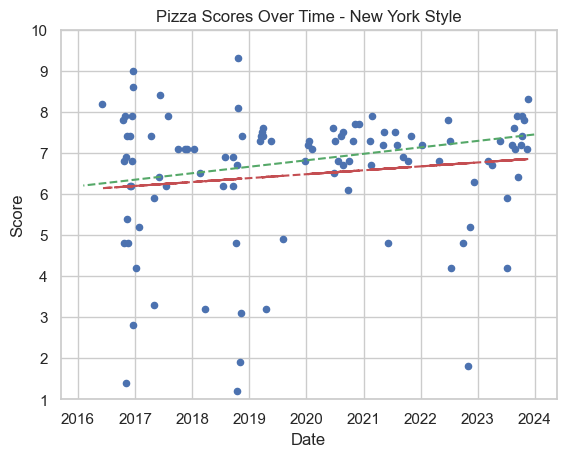

In [96]:
# Create the relplot
#rel_plot = sns.relplot(data=football_pizza_reviews, x='Date', y='Score:', kind='scatter')

x = mdates.date2num(new_york_style_reviews['Date'])
y = new_york_style_reviews['Score:']

z = np.polyfit(x, y, 1)
p = np.poly1d(z)

#print slope
slope = z[0]
print("Slope of the trendline:", slope)

new_york_style_reviews.plot('Date', 'Score:', kind='scatter')
plt.plot(x, p(x), "r--")
plt.plot(a,q(a), "g--")
plt.ylim(1, 10)
plt.title("Pizza Scores Over Time - New York Style")
plt.xlabel("Date")
plt.ylabel("Score")
plt.ylim((1, 10))
plt.show()


Slope of the trendline: -7.688311508386146e-05


(1.0, 10.0)

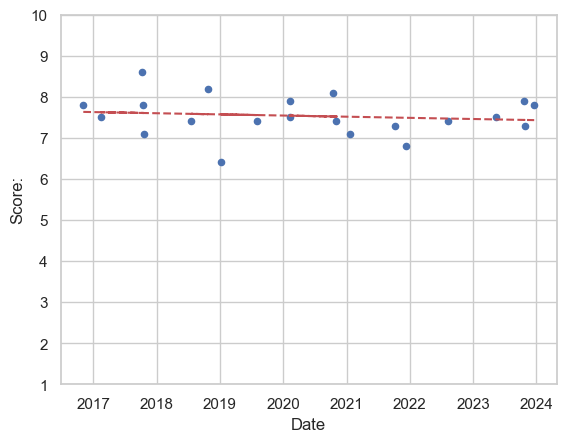

In [61]:
# Create the relplot
#rel_plot = sns.relplot(data=football_pizza_reviews, x='Date', y='Score:', kind='scatter')

x = mdates.date2num(football_pizza_reviews['Date'])
y = football_pizza_reviews['Score:']

z = np.polyfit(x, y, 1)
p = np.poly1d(z)

#print slope
slope = z[0]
print("Slope of the trendline:", slope)

football_pizza_reviews.plot('Date', 'Score:', kind='scatter')
plt.plot(x, p(x), "r--")
plt.ylim(1, 10)



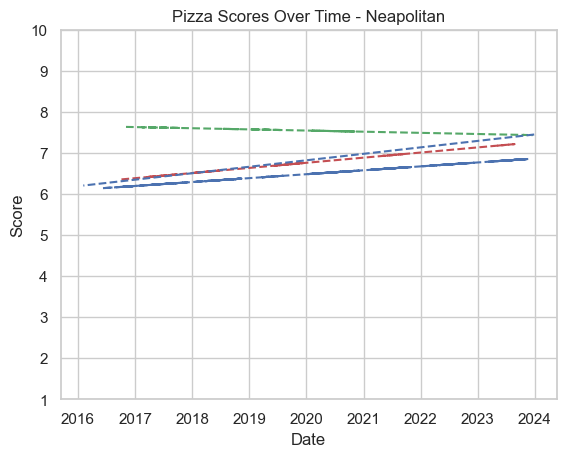

In [119]:
#trend line comparisons

#neapolitan

def trend_line(data):
    x = mdates.date2num(data['Date'])
    y = data['Score:']

    z = np.polyfit(x, y, 1)
    p = np.poly1d(z)   

    return [x,y,z,p(x)]


neopolitan = trend_line(neopolitan_reviews)
football = trend_line(football_pizza_reviews)
nyc = trend_line(new_york_style_reviews)


plt.plot(neopolitan[0], neopolitan[3], "r--")
plt.plot(football[0], football[3], "g--")
plt.plot(nyc[0], nyc[3], "b--")
plt.plot(mdates.num2date(trend_data[0]), trend_data[3], "b--")

plt.ylim(1, 10)
plt.title("Pizza Scores Over Time - Neapolitan")
plt.xlabel("Date")
plt.ylabel("Score")
plt.ylim((1, 10))
plt.show()
